In [1]:
# https://www.kaggle.com/theoviel/ncaa-starter-the-simpler-the-better
import os #ファイル、ディレクトリ操作
import re
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

pd.set_option('display.max_columns', None)

In [2]:
DATA_PATH = 'C:\\Users\\shota\\OneDrive\\ドキュメント\\Data\\Kaggle\\kc_NCAAW\\WDataFiles_Stage2\\'
DATA_PATH_M = 'C:\\Users\\shota\\OneDrive\\ドキュメント\\Data\\Kaggle\\kc_NCAAW\\WDataFiles_Stage2\\'

for filename in os.listdir(DATA_PATH):
    print(filename)

Cities.csv
Conferences.csv
WGameCities.csv
WNCAATourneyCompactResults.csv
WNCAATourneyDetailedResults.csv
WNCAATourneySeeds.csv
WNCAATourneySlots.csv
WRegularSeasonCompactResults.csv
WRegularSeasonDetailedResults.csv
WSampleSubmissionStage2.csv
WSeasons.csv
WTeamConferences.csv
WTeams.csv
WTeamSpellings.csv


In [3]:
df_seeds = pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv")
df_seeds.head()

,Season,Seed,TeamID
0,1998,W01,3330
1,1998,W02,3163
2,1998,W03,3112
3,1998,W04,3301
4,1998,W05,3272


In [4]:
df_season_results = pd.read_csv(DATA_PATH + "WRegularSeasonCompactResults.csv")
df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [5]:
df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']

In [6]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,ScoreGap
0,1998,18,3104,91,3202,41,50
1,1998,18,3163,87,3221,76,11
2,1998,18,3222,66,3261,59,7
3,1998,18,3307,69,3365,62,7
4,1998,18,3349,115,3411,35,80


In [7]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

In [8]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID":"TeamID"})

In [9]:
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

In [10]:
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

In [11]:
gap_loss

,Season,TeamID,GapLosses
0,1998,3102,27.850000
1,1998,3103,18.611111
2,1998,3104,5.666667
3,1998,3106,14.466667
4,1998,3108,16.636364
...,...,...,...
8030,2021,3467,8.500000
8031,2021,3468,20.352941
8032,2021,3469,23.000000
8033,2021,3470,15.062500


In [12]:
#Merge
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [13]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [14]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')

In [15]:
df_features_season.fillna(0, inplace=True)

In [16]:
#Compute features
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] -
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

In [18]:
df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)

In [19]:
df_features_season

,Season,TeamID,WinRatio,GapAvg
0,1998,3102,0.166667,-20.625000
1,1998,3103,0.379310,-5.862069
2,1998,3104,0.700000,13.433333
3,1998,3106,0.285714,-7.952381
4,1998,3108,0.521739,1.304348
...,...,...,...,...
8044,2021,3467,0.333333,-2.666667
8045,2021,3468,0.227273,-14.409091
8046,2021,3469,0.000000,-23.000000
8047,2021,3470,0.238095,-8.428571


In [20]:
#Tourney results
df_tourney_results = pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv")
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [21]:
def get_round(day):
#     round_dic = {134: 0, 135: 0, 136: 1, 137: 1, 138: 2, 139: 2, 143: 3, 144: 3, 145: 4, 146: 4, 152: 5, 154: 6}
    round_dic = {137: 0, 138: 0, 139: 1, 140: 1, 141: 2, 144: 3, 145: 3, 146: 4, 147: 4, 148: 4, 151:5, 153: 5, 155: 6} # probably wrong but I don't use it anyways
    try:
        return round_dic[day]
    except:
        print(f'Unknow day : {day}')
        return 0

In [22]:
df_tourney_results['Round'] = df_tourney_results['DayNum'].apply(get_round)

In [23]:
df_tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Round
0,1998,137,3104,94,3422,46,0
1,1998,137,3112,75,3365,63,0
2,1998,137,3163,93,3193,52,0
3,1998,137,3198,59,3266,45,0
4,1998,137,3203,74,3208,72,0


In [24]:
# train data
df = df_tourney_results.copy()
df = df[df['Season'] >= 2003].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Round
0,2003,138,3130,73,3330,72,0
1,2003,138,3160,84,3140,45,0
2,2003,138,3208,80,3150,61,0
3,2003,138,3261,86,3402,50,0
4,2003,138,3278,68,3408,48,0


In [25]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [26]:
df = pd.merge(
    df,
    df_seeds,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [27]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))    #正規表現で置換: re.sub, re.subn

In [28]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [29]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Round,SeedW,SeedL
0,2003,138,3130,73,3330,72,0,5,12
1,2003,138,3160,84,3140,45,0,6,11
2,2003,138,3208,80,3150,61,0,5,12
3,2003,138,3261,86,3402,50,0,1,16
4,2003,138,3278,68,3408,48,0,6,11


In [30]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'GapWins': 'GapWinsW',
    'GapLosses': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
}).drop(columns='TeamID', axis=1)

In [31]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'GapWins': 'GapWinsL',
    'GapLosses': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL'
}).drop(columns='TeamID', axis=1)

In [32]:
df.shape

(1071, 13)

In [33]:
def add_loosing_matches(win_df):
    win_rename={
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
        "SeedW": "SeedA", 
        "SeedL": "SeedB",
        'WinRatioW' : 'WinRatioA',
        'WinRatioL' : 'WinRatioB',
        'GapAvgW' : 'GapAvgA',
        'GapAvgL' : 'GapAvgB',
#         "OrdinalRankW": "OrdinalRankA",
#         "OrdinalRankL": "OrdinalRankB",
    }
    
    lose_rename={
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
        "SeedW": "SeedB", 
        "SeedL": "SeedA",
        'GapAvgW' : 'GapAvgB',
        'GapAvgL' : 'GapAvgA',
        'WinRatioW' : 'WinRatioB',
        'WinRatioL' : 'WinRatioA',
#         "OrdinalRankW": "OrdinalRankB",
#         "OrdinalRankL": "OrdinalRankA",
    }
    
    win_df = win_df.copy()
    lose_df = win_df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], 0, sort=False)

In [34]:
df = add_loosing_matches(df)

In [35]:
df

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,Round,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB
0,2003,138,3130,73,3330,72,0,5,12,0.714286,10.821429,0.677419,8.483871
1,2003,138,3160,84,3140,45,0,6,11,0.758621,8.413793,0.633333,6.466667
2,2003,138,3208,80,3150,61,0,5,12,0.678571,12.928571,0.724138,7.034483
3,2003,138,3261,86,3402,50,0,1,16,0.900000,18.500000,0.580645,-0.161290
4,2003,138,3278,68,3408,48,0,6,11,0.821429,14.000000,0.678571,8.821429
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,2019,147,3234,53,3124,85,4,2,1,0.812500,12.250000,0.968750,25.937500
1067,2019,147,3390,68,3323,84,4,2,1,0.875000,14.000000,0.909091,25.000000
1068,2019,151,3332,67,3124,72,5,2,1,0.875000,21.406250,0.968750,25.937500
1069,2019,151,3163,76,3323,81,5,2,1,0.939394,28.030303,0.909091,25.000000


In [36]:
df['SeedDiff'] = df['SeedA'] - df['SeedB']
df['WinRatioDiff'] = df['WinRatioA'] - df['WinRatioB']
df['GapAvgDiff'] = df['GapAvgA'] - df['GapAvgB']

In [37]:
df.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,Round,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff
0,2003,138,3130,73,3330,72,0,5,12,0.714286,10.821429,0.677419,8.483871,-7,0.036866,2.337558
1,2003,138,3160,84,3140,45,0,6,11,0.758621,8.413793,0.633333,6.466667,-5,0.125287,1.947126
2,2003,138,3208,80,3150,61,0,5,12,0.678571,12.928571,0.724138,7.034483,-7,-0.045567,5.894089
3,2003,138,3261,86,3402,50,0,1,16,0.900000,18.500000,0.580645,-0.161290,-15,0.319355,18.661290
4,2003,138,3278,68,3408,48,0,6,11,0.821429,14.000000,0.678571,8.821429,-5,0.142857,5.178571


In [38]:
df_test = pd.read_csv(DATA_PATH + "WSampleSubmissionStage2.csv")

In [39]:
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [40]:
df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB
0,2021_3104_3112,0.5,2021,3104,3112
1,2021_3104_3116,0.5,2021,3104,3116
2,2021_3104_3124,0.5,2021,3104,3124
3,2021_3104_3125,0.5,2021,3104,3125
4,2021_3104_3133,0.5,2021,3104,3133


In [41]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'})

In [42]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'})

In [43]:
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

In [44]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'GapWins': 'GapWinsA',
    'GapLosses': 'GapLossesA',
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
}).drop(columns='TeamID', axis=1)

In [45]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'GapWins': 'GapWinsB',
    'GapLosses': 'GapLossesB',
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB'
}).drop(columns='TeamID', axis=1)

In [46]:
df_test['SeedDiff'] = df_test['SeedA'] - df_test['SeedB']
df_test['WinRatioDiff'] = df_test['WinRatioA'] - df_test['WinRatioB']
df_test['GapAvgDiff'] = df_test['GapAvgA'] - df_test['GapAvgB']

In [47]:
df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff
0,2021_3104_3112,0.5,2021,3104,3112,7,3,0.64,4.76,0.761905,10.523810,4,-0.121905,-5.763810
1,2021_3104_3116,0.5,2021,3104,3116,7,4,0.64,4.76,0.703704,9.000000,3,-0.063704,-4.240000
2,2021_3104_3124,0.5,2021,3104,3124,7,2,0.64,4.76,0.925926,27.111111,5,-0.285926,-22.351111
3,2021_3104_3125,0.5,2021,3104,3125,7,12,0.64,4.76,0.800000,12.320000,-5,-0.160000,-7.560000
4,2021_3104_3133,0.5,2021,3104,3133,7,11,0.64,4.76,0.592593,4.592593,-4,0.047407,0.167407


In [48]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

In [49]:
features = [
    'SeedA',
    'SeedB',
    'WinRatioA',
    'GapAvgA',
    'WinRatioB',
    'GapAvgB',
    'SeedDiff',
    'WinRatioDiff',
    'GapAvgDiff',
]

In [50]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

In [51]:
def kfold_reg(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[10:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
        
        if mode == "reg":
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            model = LogisticRegression(C=10)
            
        model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
            pred = (pred - pred.min()) / (pred.max() - pred.min())
        else:
            pred = model.predict_proba(df_val[features])[:, 1]      #predict_probaは確率を返す
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict_proba(df_test[features])[:, 1]
                
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred)
            plt.show()
        
        loss = log_loss(df_val['WinA'].values, pred)
        cvs.append(loss)

        if verbose:
            print(f'\t -> Scored {loss:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests

In [52]:
pred_tests = kfold_reg(df, df_test, plot=False, verbose=1, mode="cls")
#ログ損失、Logarithmic Loss、Log lossなどと言われていますが、予測された確率とその結果の乖離を交差エントロピーを利用して数値化しているものです
#モデルがいいほど0に近くなり、完璧なモデルでLog損失が0になります


Validating on season 2013
	 -> Scored 0.445

Validating on season 2014
	 -> Scored 0.427

Validating on season 2015
	 -> Scored 0.371

Validating on season 2016
	 -> Scored 0.452

Validating on season 2017
	 -> Scored 0.448

Validating on season 2018
	 -> Scored 0.500

Validating on season 2019
	 -> Scored 0.387

 Local CV is 0.433


In [53]:
pred_test = np.mean(pred_tests, 0)

In [54]:
sub = df_test[['ID', 'Pred']].copy()
sub['Pred'] = pred_test
sub.to_csv('kc_NCAAW_submission2.csv', index=False)

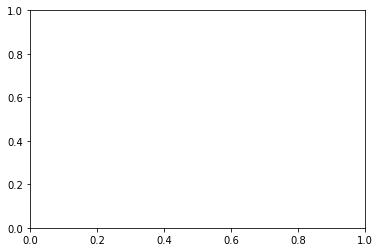

In [55]:
_ = sns.histplot()

In [56]:
sub2 = sub[sub['ID'].str.contains('2021')]

In [57]:
sub2

,ID,Pred
0,2021_3104_3112,0.231653
1,2021_3104_3116,0.272983
2,2021_3104_3124,0.055171
3,2021_3104_3125,0.685468
4,2021_3104_3133,0.686575
...,...,...
2011,2021_3450_3460,0.644088
2012,2021_3450_3461,0.711786
2013,2021_3452_3460,0.843037
2014,2021_3452_3461,0.879767


In [59]:
sub2.to_csv('kc_NCAAW_submission2.csv', index=False)